***Telco Customer Churn dataset***

In [ ]:
import pandas as pd
df = pd.read_csv(r"/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Basic inspection
shape = df.shape
info = df.info()
desc = df.describe(include='all')
missing_values = df.isnull().sum()
target_distribution = df['Churn'].value_counts(normalize=True) * 100

(shape, missing_values.head(), target_distribution)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


((7043, 21),
 customerID       0
 gender           0
 SeniorCitizen    0
 Partner          0
 Dependents       0
 dtype: int64,
 Churn
 No     73.463013
 Yes    26.536987
 Name: proportion, dtype: float64)

**Data** **Preprocessing**

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import numpy as np

In [ ]:
# Copy dataframe for preprocessing
df_pre = df.copy()

In [ ]:

# --- 1. Handle missing values ---
# Convert TotalCharges to numeric (coerce errors to NaN)
df_pre['TotalCharges'] = pd.to_numeric(df_pre['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with median
df_pre['TotalCharges'].fillna(df_pre['TotalCharges'].median(), inplace=True)


/tmp/ipython-input-583826109.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pre['TotalCharges'].fillna(df_pre['TotalCharges'].median(), inplace=True)


In [ ]:
df_pre

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [ ]:
# --- 2. Convert categorical variables ---
# Drop customerID (not useful)
#df_pre.drop('customerID', axis=1, inplace=True)

# Target Encoding (Churn)
df_pre['Churn'] = df_pre['Churn'].map({'No': 0, 'Yes': 1})

# Separate features
X = df_pre.drop('Churn', axis=1)
y = df_pre['Churn']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

# One-Hot Encoding categorical variables
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [ ]:
X_encoded = X_encoded.astype(int)
X_encoded

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,customerID_0013-SMEOE,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29,29,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56,1889,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53,108,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42,1840,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70,151,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84,1990,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1
7039,0,72,103,7362,0,0,0,0,0,0,...,0,1,0,1,1,0,1,1,0,0
7040,0,11,29,346,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7041,1,4,74,306,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
# --- 3. Feature Scaling ---
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# Final preprocessed data
X_processed = X_encoded
y_processed = y

(X_processed.shape, y_processed.value_counts())


((7043, 7072),
 Churn
 0    5174
 1    1869
 Name: count, dtype: int64)

**Exploratory Data Analysis (EDA)**

/tmp/ipython-input-2223966033.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='pastel', legend=False)


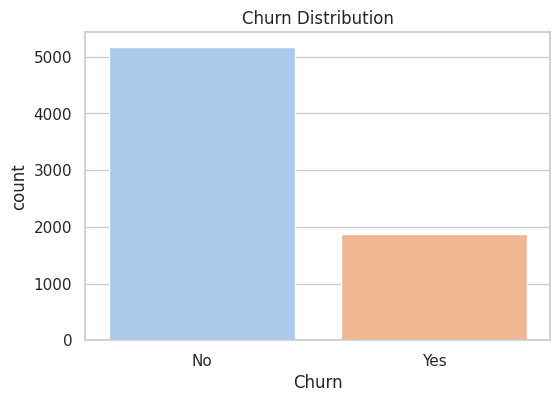

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", palette="Set2")

# --- 1. Churn Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='pastel', legend=False)
plt.title("Churn Distribution")
plt.show()



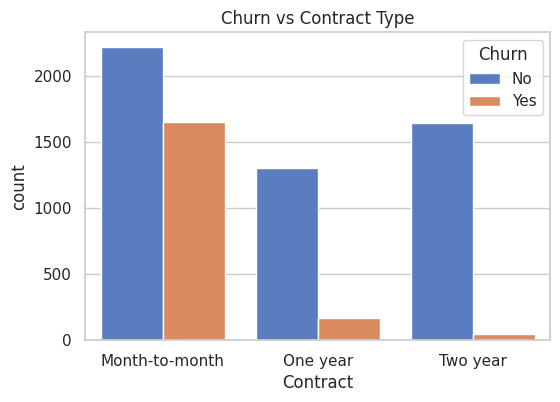

In [ ]:
# --- 2. Churn vs Contract ---
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=df, palette='muted')
plt.title("Churn vs Contract Type")
plt.show()



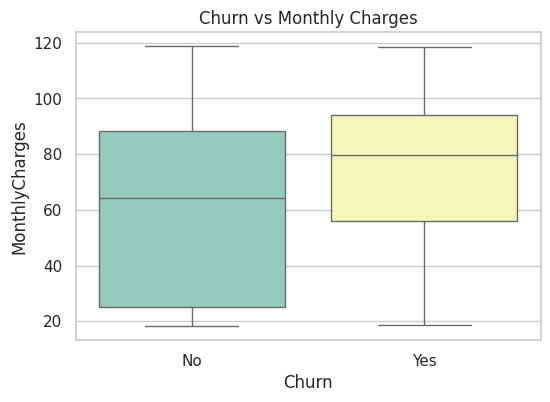

In [ ]:
# --- 3. Churn vs MonthlyCharges ---
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', hue='Churn', data=df, palette='Set3', legend=False)
plt.title("Churn vs Monthly Charges")
plt.show()



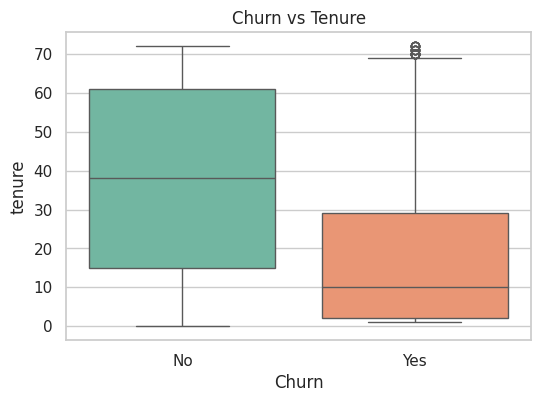

In [ ]:
# --- 4. Churn vs Tenure ---
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='tenure', hue='Churn', data=df, palette='Set2', legend=False)
plt.title("Churn vs Tenure")
plt.show()



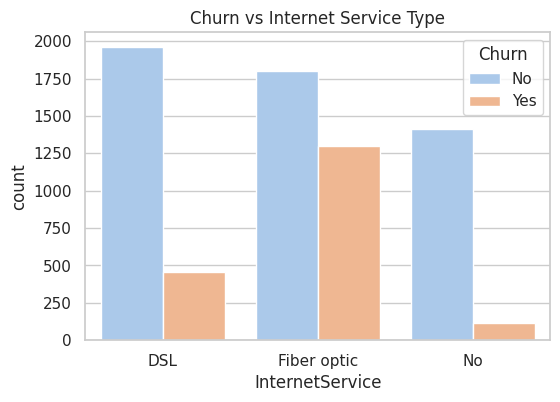

In [ ]:
# --- 5. Churn vs InternetService ---
plt.figure(figsize=(6,4))
sns.countplot(x='InternetService', hue='Churn', data=df, palette='pastel')
plt.title("Churn vs Internet Service Type")
plt.show()



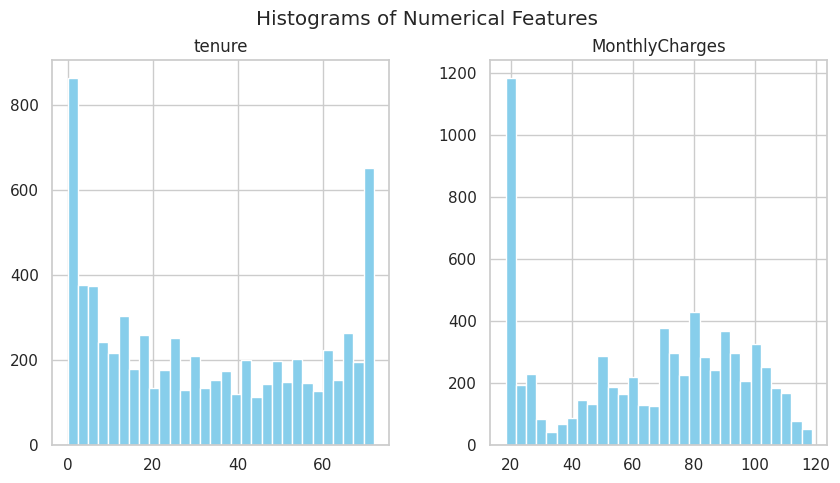

In [ ]:
# --- 6. Histograms ---
df[['tenure','MonthlyCharges']].hist(bins=30, figsize=(10,5), color='skyblue')
plt.suptitle("Histograms of Numerical Features")
plt.show()



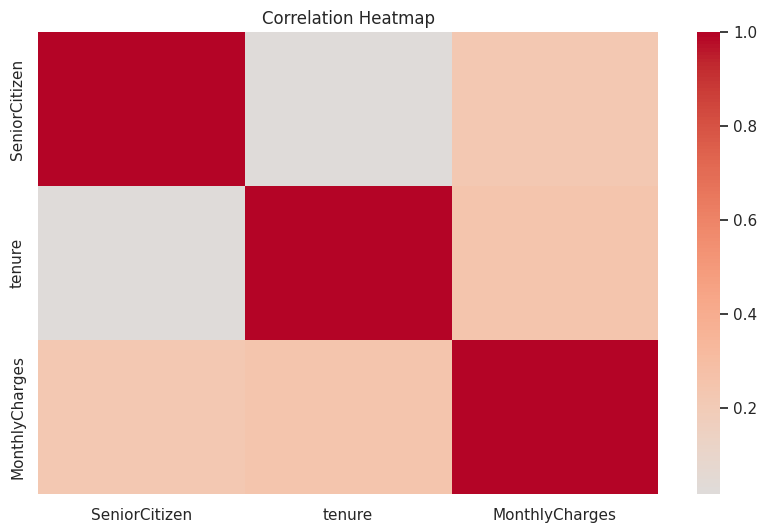

In [ ]:
# --- 7. Correlation Heatmap ---
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

**Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Create New Features ---

# Average Monthly Spend (avoid division by zero)
df_pre['AvgSpend'] = df_pre.apply(lambda x: x['TotalCharges']/x['tenure']
                                  if x['tenure'] > 0 else 0, axis=1)

# Tenure Group (binning tenure)
df_pre['TenureGroup'] = pd.cut(df_pre['tenure'],
                               bins=[0, 12, 24, 1000],
                               labels=['0-12 months', '13-24 months', '25+ months'])

# Service Count (number of services subscribed)
services = ['PhoneService','MultipleLines','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection',
            'TechSupport','StreamingTV','StreamingMovies']
df_pre['ServiceCount'] = df_pre[services].apply(lambda row: np.sum(row == 'Yes'), axis=1)




In [ ]:
# --- 2. Drop Irrelevant or Correlated Features ---
# Example: Drop CustomerID, TotalCharges (since it ≈ MonthlyCharges × tenure)
df_pre = df_pre.drop(columns=['customerID', 'TotalCharges'], errors='ignore')




In [ ]:
# --- 3. Encode Categorical Features ---
df_encoded = pd.get_dummies(df_pre, drop_first=True)




In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Identify the target column
if 'Churn_Yes' in df_encoded.columns:
    y = df_encoded['Churn_Yes']
    X = df_encoded.drop('Churn_Yes', axis=1)
elif 'Churn' in df_encoded.columns:
    y = df_encoded['Churn']
    X = df_encoded.drop('Churn', axis=1)
else:
    raise KeyError("Target column not found. Check if it's 'Churn' or 'Churn_Yes'.")

# Split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Shape of training data after SMOTE:", X_train_smote.shape)
print("Distribution of target variable after SMOTE:\n", y_train_smote.value_counts(normalize=True))


Shape of training data after SMOTE: (7244, 33)
Distribution of target variable after SMOTE:
 Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


**Model Building**

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop("Churn", axis=1)
y = df["Churn"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    }


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(
    solver="liblinear",   # faster + works better on small/medium data
    max_iter=1000,        # increase iterations
    random_state=42
)
log_reg.fit(X_train_res_scaled, y_train_res)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_res_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

# Now train Logistic Regression with numeric labels
log_reg.fit(X_train_res_scaled, y_train_res_enc)

# Evaluate with encoded y_test
results = {}
results["Logistic Regression"] = evaluate_model(log_reg, X_test_scaled, y_test_enc)
print(results)

{'Logistic Regression': {'Accuracy': 0.6857548509228585, 'Precision': 0.45090562440419446, 'Recall': 0.8431372549019608, 'F1': 0.5875776397515527, 'ROC_AUC': np.float64(0.8234984012349081)}}


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd # Import pandas

#  Evaluation function (fixed)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Ensure y_test and y_pred are numerical if they are not already
    y_test_numeric = y_test.map({'No': 0, 'Yes': 1}) if y_test.dtype == 'object' else y_test
    y_pred_numeric = pd.Series(y_pred).map({'No': 0, 'Yes': 1}) if pd.Series(y_pred).dtype == 'object' else pd.Series(y_pred)


    return {
        "Accuracy": accuracy_score(y_test_numeric, y_pred_numeric),
        "Precision": precision_score(y_test_numeric, y_pred_numeric, pos_label=1),
        "Recall": recall_score(y_test_numeric, y_pred_numeric, pos_label=1),
        "F1": f1_score(y_test_numeric, y_pred_numeric, pos_label=1),
        "ROC_AUC": roc_auc_score(y_test_numeric, model.predict_proba(X_test)[:,1]) if hasattr(model, "predict_proba") else "N/A"
    }

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

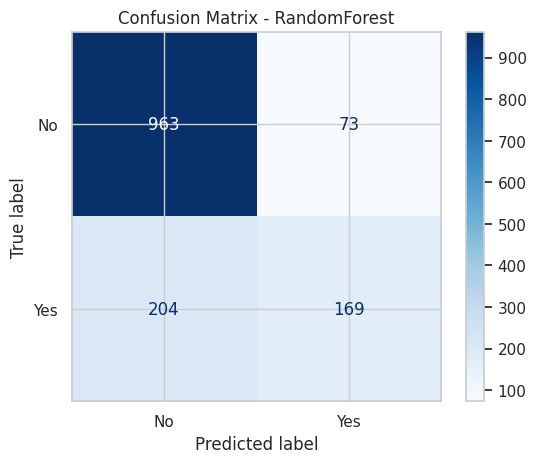

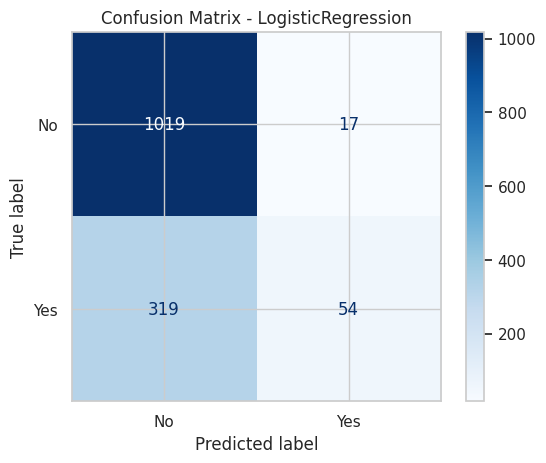

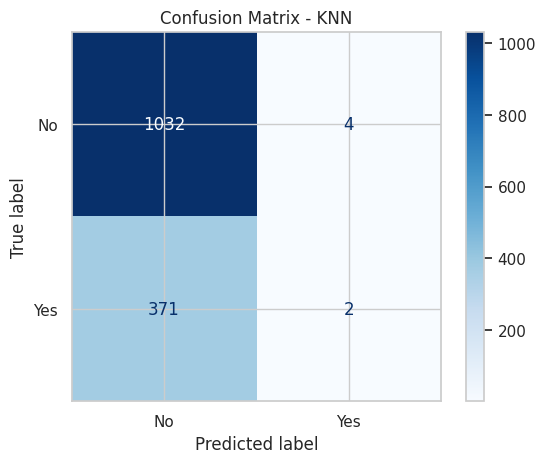

In [ ]:
# -----------------------------
# Import libraries
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# Split the dataset
# -----------------------------
# X = features, y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Encode target if needed
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# -----------------------------
# Define models
# -----------------------------
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=500),
    'KNN': KNeighborsClassifier()
}

# -----------------------------
# Train models and save them
# -----------------------------
fitted_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_enc)
    fitted_models[name] = model

# -----------------------------
# Plot confusion matrices for all models
# -----------------------------
for name, model in fitted_models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


RandomForest Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': None}
RandomForest Best CV Accuracy: 0.7984



/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LogisticRegression Best Params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
LogisticRegression Best CV Accuracy: 0.7444

KNN Best Params: {'weights': 'distance', 'n_neighbors': 3}
KNN Best CV Accuracy: 0.7364

--- RandomForest ---
Test Accuracy: 0.8048
              precision    recall  f1-score   support

          No       0.83      0.93      0.87      1036
         Yes       0.70      0.46      0.56       373

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.72      1409
weighted avg       0.79      0.80      0.79      1409



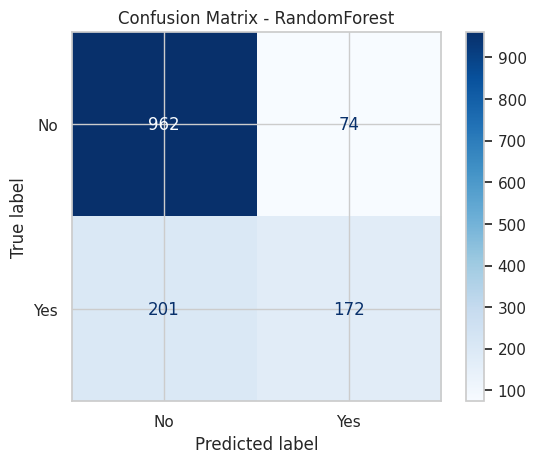

--- LogisticRegression ---
Test Accuracy: 0.7622
              precision    recall  f1-score   support

          No       0.76      0.98      0.86      1036
         Yes       0.77      0.14      0.24       373

    accuracy                           0.76      1409
   macro avg       0.77      0.56      0.55      1409
weighted avg       0.76      0.76      0.70      1409



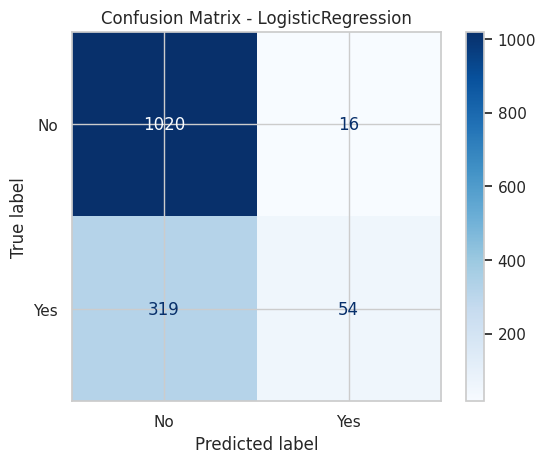

--- KNN ---
Test Accuracy: 0.7367
              precision    recall  f1-score   support

          No       0.74      0.99      0.85      1036
         Yes       0.56      0.03      0.05       373

    accuracy                           0.74      1409
   macro avg       0.65      0.51      0.45      1409
weighted avg       0.69      0.74      0.64      1409



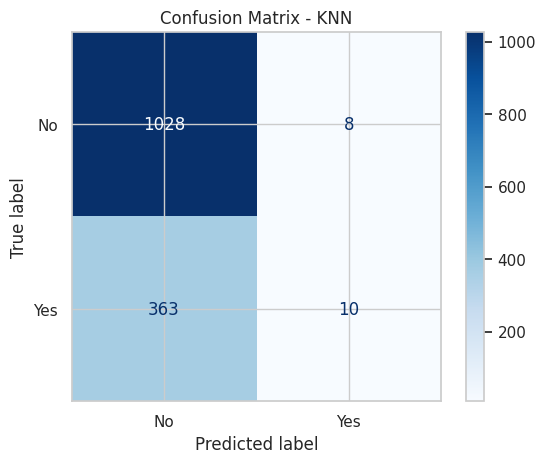

In [ ]:
# -----------------------------
# Import libraries
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# -----------------------------
# Split dataset
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Encode target
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

# -----------------------------
# Define models and hyperparameters
# -----------------------------
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=500),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    }
}

# -----------------------------
# Hyperparameter tuning with GridSearchCV
# -----------------------------
from sklearn.model_selection import RandomizedSearchCV

fitted_models = {}
for name, mp in models_params.items():
    rs = RandomizedSearchCV(mp['model'], mp['params'], n_iter=5, cv=3, scoring='accuracy', random_state=42)
    rs.fit(X_train_scaled, y_train_enc)
    fitted_models[name] = rs.best_estimator_
    print(f"{name} Best Params: {rs.best_params_}")
    print(f"{name} Best CV Accuracy: {rs.best_score_:.4f}\n")


# -----------------------------
# Evaluate tuned models
# -----------------------------
for name, model in fitted_models.items():
    y_pred = model.predict(X_test_scaled)
    print(f"--- {name} ---")
    print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
    print(classification_report(y_test_enc, y_pred, target_names=encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

Training LogisticRegression...
Test Accuracy: 0.7615
              precision    recall  f1-score   support

          No       0.76      0.98      0.86      1036
         Yes       0.76      0.14      0.24       373

    accuracy                           0.76      1409
   macro avg       0.76      0.56      0.55      1409
weighted avg       0.76      0.76      0.70      1409



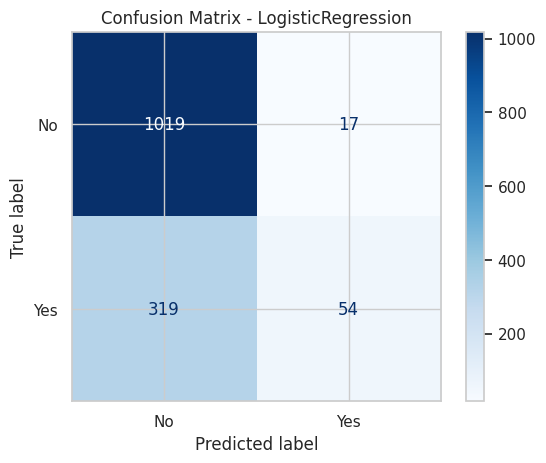

Training DecisionTree...
Test Accuracy: 0.7736
              precision    recall  f1-score   support

          No       0.83      0.86      0.85      1036
         Yes       0.58      0.52      0.55       373

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.77      0.77      1409



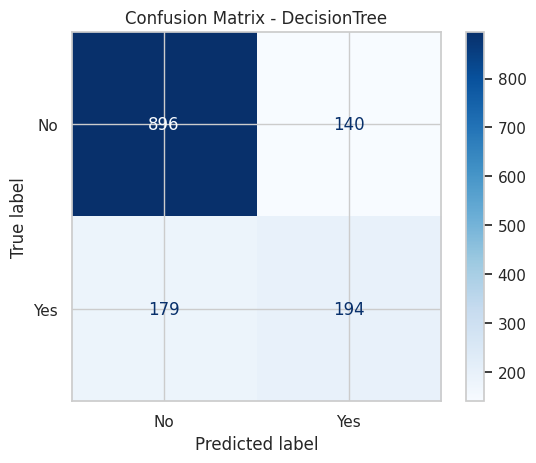

Training RandomForest...
Test Accuracy: 0.7942
              precision    recall  f1-score   support

          No       0.82      0.93      0.87      1036
         Yes       0.68      0.42      0.52       373

    accuracy                           0.79      1409
   macro avg       0.75      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



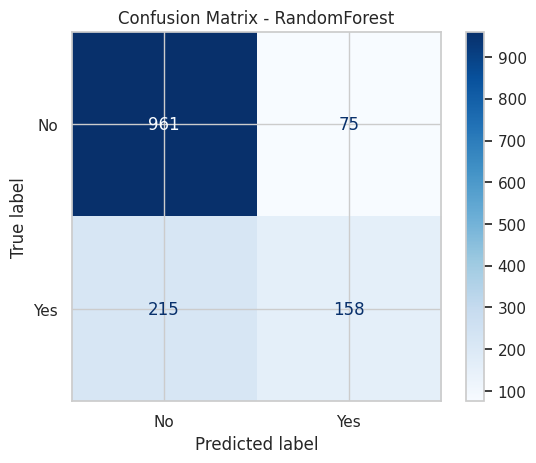

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:12:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 0.7928
              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1036
         Yes       0.63      0.53      0.58       373

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



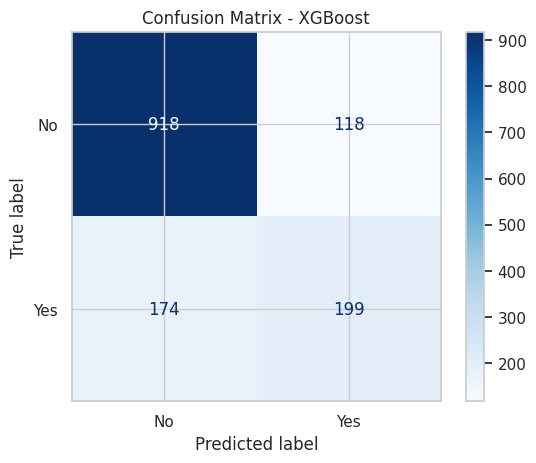

In [ ]:
# -----------------------------
# Imports
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# -----------------------------
# Split dataset
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Handle class imbalance with SMOTE
# -----------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# -----------------------------
# Encode target labels
# -----------------------------
le = LabelEncoder()
y_train_res_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

# -----------------------------
# Define models
# -----------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# -----------------------------
# Train models and evaluate
# -----------------------------
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_res, y_train_res_enc)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")

    # Classification report
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


### **8. Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
import pandas as pd # Import pandas
import numpy as np

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# --- Data Loading and Preprocessing (Moved from previous cells) ---
df = pd.read_csv(r"/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_pre = df.copy()

# Handle missing values in TotalCharges
df_pre['TotalCharges'] = pd.to_numeric(df_pre['TotalCharges'], errors='coerce')
df_pre['TotalCharges'].fillna(df_pre['TotalCharges'].median(), inplace=True)

# Convert Churn to numeric
df_pre['Churn'] = df_pre['Churn'].map({'No': 0, 'Yes': 1})

# --- Feature Engineering (Moved from previous cells) ---
# Average Monthly Spend
df_pre['AvgSpend'] = df_pre.apply(lambda x: x['TotalCharges']/x['tenure']
                                  if x['tenure'] > 0 else 0, axis=1)

# Tenure Group (binning tenure)
df_pre['TenureGroup'] = pd.cut(df_pre['tenure'],
                               bins=[0, 12, 24, 1000],
                               labels=['0-12 months', '13-24 months', '25+ months'], right=False) # use right=False for correct binning

# Service Count
services = ['PhoneService','MultipleLines','InternetService',
            'OnlineSecurity','OnlineBackup','DeviceProtection',
            'TechSupport','StreamingTV','StreamingMovies']

# Handle 'No internet service' and 'No phone service' before counting
def count_active_services(row):
    count = 0
    for col in services:
        if col in row and row[col] not in ['No internet service', 'No phone service', 'No']:
             count += 1
    # Add PhoneService if applicable and not 'No phone service'
    if 'PhoneService' in row and row['PhoneService'] != 'No phone service' and row['PhoneService'] == 'Yes':
      count +=1
    # Add InternetService if applicable and not 'No internet service'
    if 'InternetService' in row and row['InternetService'] != 'No internet service' and row['InternetService'] != 'No':
      count +=1
    return count

df_pre['ServiceCount'] = df_pre.apply(count_active_services, axis=1)


# Drop irrelevant features
df_pre = df_pre.drop(columns=['customerID', 'TotalCharges'], errors='ignore') # Drop TotalCharges after using it for AvgSpend

# One-Hot Encode categorical features (excluding Churn and engineered 'TenureGroup')
categorical_cols_to_encode = df_pre.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Churn' in categorical_cols_to_encode:
    categorical_cols_to_encode.remove('Churn')

df_encoded = pd.get_dummies(df_pre, columns=categorical_cols_to_encode, drop_first=True)


# Define X and y after all preprocessing and feature engineering
if 'Churn_Yes' in df_encoded.columns:
    y = df_encoded['Churn_Yes']
    X = df_encoded.drop('Churn_Yes', axis=1)
elif 'Churn' in df_encoded.columns: # Should be 'Churn' after mapping
    y = df_encoded['Churn']
    X = df_encoded.drop('Churn', axis=1)
else:
    raise KeyError("Target column not found. Check if it's 'Churn' or 'Churn_Yes'.")


# -----------------------------
# Split dataset
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# -----------------------------
# Handle class imbalance with SMOTE on training data
# -----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# -----------------------------
# Scale features (after splitting and SMOTE on training data)
# -----------------------------
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Encode target labels (after SMOTE)
# -----------------------------
le = LabelEncoder()
y_train_res_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

# Define models and their hyperparameter distributions for tuning
param_distributions = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']  # Both support l1 & l2
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "LightGBM": {
        'model': LGBMClassifier(random_state=42, is_unbalance=True, verbose=-1),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'num_leaves': [31, 64, 128],
            'max_depth': [-1, 10, 20],
            'min_child_samples': [20, 50, 100]
        }
    },
    "XGBoost": {
        'model': XGBClassifier(random_state=42, scale_pos_weight=1,
                               use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 6, 10],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
        }
    },
    "SVM": {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC(probability=True, random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'svc__C': [0.1, 1, 10],
            'svc__gamma': ['scale', 'auto'],
            'svc__kernel': ['linear', 'rbf']
        }
    }
}

tuned_models = {}
best_params = {}
best_scores = {}

# Assuming X_train_res_scaled, y_train_res_enc are available from previous steps
for name, mp in param_distributions.items():
    print(f"Tuning {name}...")

    random_search = RandomizedSearchCV(
        mp['model'],
        mp['params'],
        n_iter=30,        # Increased iterations for better search
        cv=3,             # 3-fold cross-validation
        scoring='recall', # Optimize for recall (important in churn/imbalanced problems)
        random_state=42,
        n_jobs=-1
    )

    # Fit the model using the scaled and resampled training data and encoded labels
    random_search.fit(X_train_res_scaled, y_train_res_enc)

    tuned_models[name] = random_search.best_estimator_
    best_params[name] = random_search.best_params_
    best_scores[name] = random_search.best_score_

    print(f"Finished tuning {name}.")
    print(f"Best parameters: {best_params[name]}")
    print(f"Best cross-validation score (Recall): {best_scores[name]:.4f}\n")

# Print all best parameters and scores
print("\n--- Summary of Hyperparameter Tuning Results ---")
for name in tuned_models:
    print(f"{name}:")
    print(f"  Best Params: {best_params[name]}")
    print(f"  Best CV Recall: {best_scores[name]:.4f}")
    print("-" * 20)

Tuning Logistic Regression...
Finished tuning Logistic Regression.
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.001}
Best cross-validation score (Recall): 0.7935

Tuning Random Forest...
Finished tuning Random Forest.
Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best cross-validation score (Recall): 0.8293

Tuning LightGBM...
Finished tuning LightGBM.
Best parameters: {'num_leaves': 128, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.2}
Best cross-validation score (Recall): 0.8061

Tuning XGBoost...
Finished tuning XGBoost.
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best cross-validation score (Recall): 0.8200

Tuning SVM...
Finished tuning SVM.
Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 0.1}
Best cross-validation score (Recall): 0.7650


--- Summary of Hyperparameter

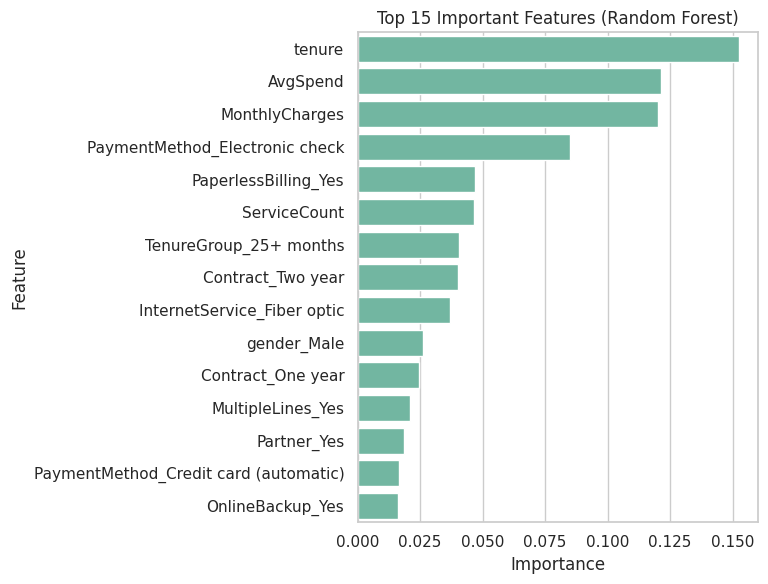

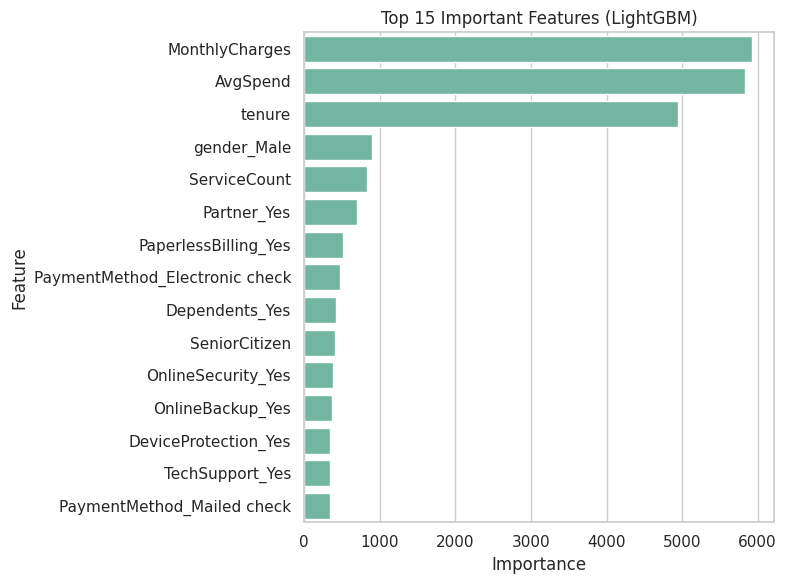

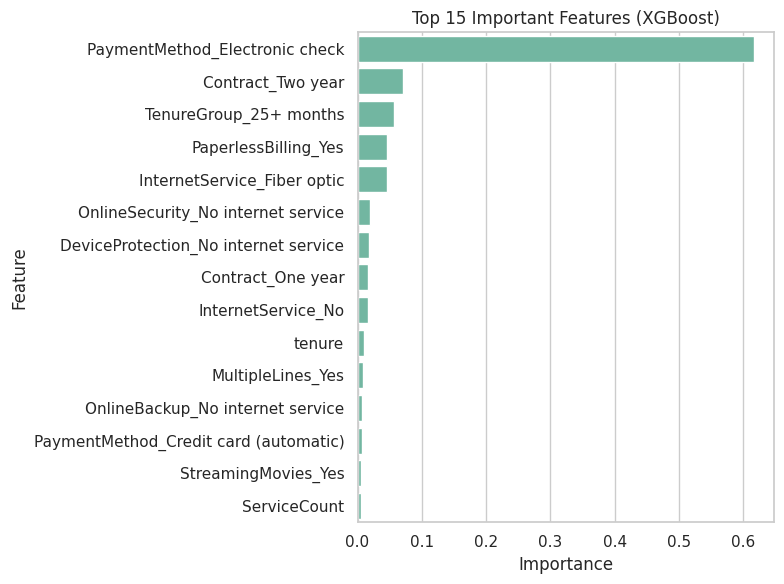

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_feature_importance(model, X, model_name):
    # Check if model has feature_importances_
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8,6))
        sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
        plt.title(f"Top 15 Important Features ({model_name})")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not provide feature importances directly.")

# Example usage:
plot_feature_importance(tuned_models["Random Forest"], X_train_res, "Random Forest")
plot_feature_importance(tuned_models["LightGBM"], X_train_res, "LightGBM")
plot_feature_importance(tuned_models["XGBoost"], X_train_res, "XGBoost")


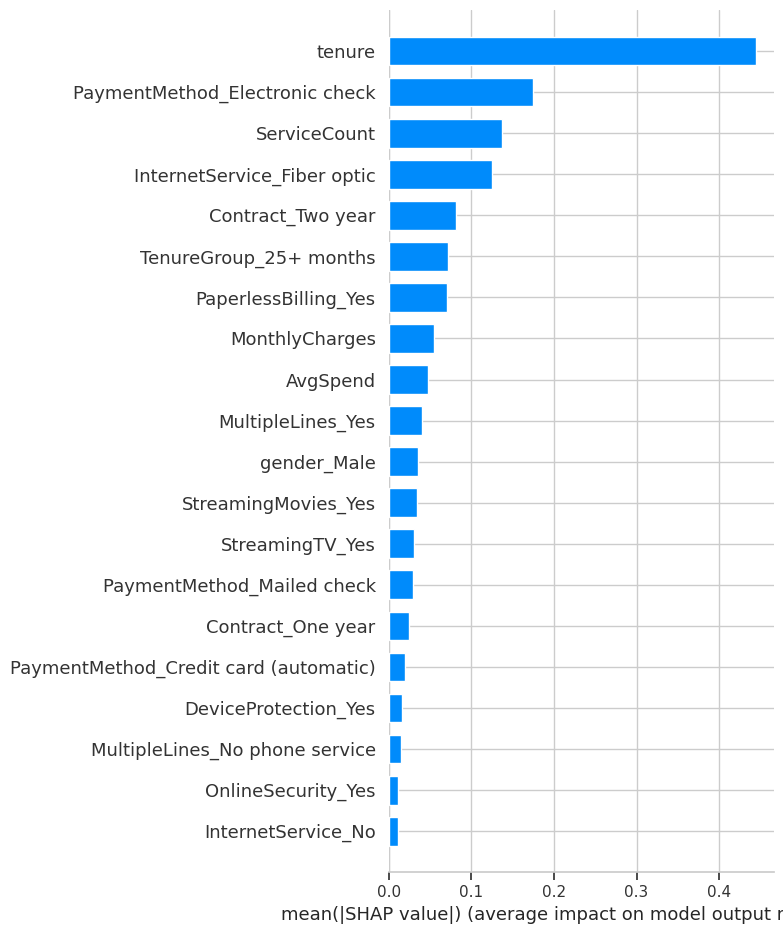

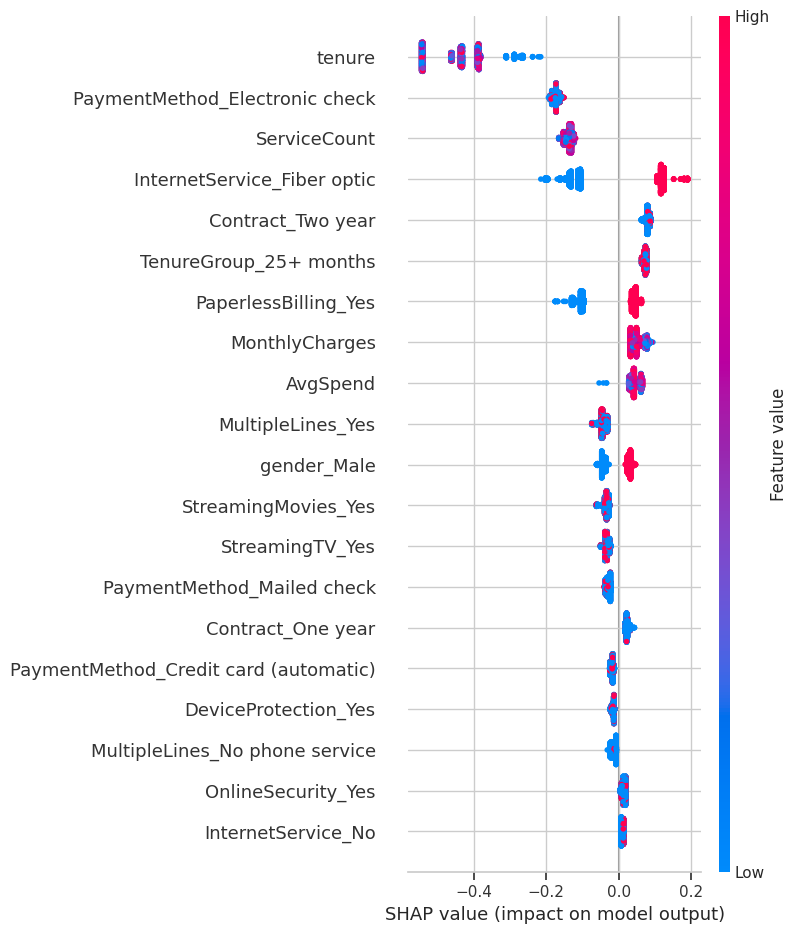

In [ ]:
import shap

# Example: SHAP for XGBoost
explainer = shap.TreeExplainer(tuned_models["XGBoost"])
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance with direction)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary (impact on predictions)
shap.summary_plot(shap_values, X_test)


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7926d2a2b3c1f5e9400dc5f67f0c948548a5c8bfdfc0175600a8a46175890334
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize explainer
explainer = LimeTabularExplainer(
    training_data=X_train_res.values,
    feature_names=X_train_res.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

# Explain a single prediction
i = 5  # pick a test sample index
exp = explainer.explain_instance(
    X_test.iloc[i].values,
    tuned_models["Random Forest"].predict_proba,  # pick a model
    num_features=10
)

# Show explanation
exp.show_in_notebook(show_table=True)


In [ ]:
import numpy as np

lr_model = tuned_models["Logistic Regression"]
coef = lr_model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train_res.columns,
    'Coefficient': coef,
    'Impact': np.exp(coef)  # odds ratio
}).sort_values(by="Coefficient", ascending=False)

print(feature_importance.head(10))


                                  Feature  Coefficient    Impact
29         PaymentMethod_Electronic check     0.346766  1.414486
27                   PaperlessBilling_Yes     0.254571  1.289908
11            InternetService_Fiber optic     0.224065  1.251152
5                             gender_Male     0.153464  1.165866
10                      MultipleLines_Yes     0.138535  1.148589
30             PaymentMethod_Mailed check     0.114099  1.120863
24                    StreamingMovies_Yes     0.104826  1.110518
22                        StreamingTV_Yes     0.097845  1.102792
28  PaymentMethod_Credit card (automatic)     0.066779  1.069059
9          MultipleLines_No phone service     0.049781  1.051041


In [ ]:
# ===== train_and_deploy.py =====
from flask import Flask, request, render_template
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import os

# ------------------ STEP 1: TRAIN & SAVE MODEL ------------------
# (Replace this with your actual churn dataset + tuned model)
X, y = make_classification(n_samples=1000, n_features=5, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Save model
joblib.dump(model, "churn_model.pkl")
print("✅ Model saved as churn_model.pkl")

# ------------------ STEP 2: FLASK APP ------------------
app = Flask(__name__)

# Load model
model = joblib.load("churn_model.pkl")

@app.route('/')
def home():
    # A simple HTML form (no need for external file)
    return '''
        <h2>📊 Customer Churn Prediction</h2>
        <form action="/predict" method="post">
            <label>Feature 1:</label><input type="text" name="f1"><br>
            <label>Feature 2:</label><input type="text" name="f2"><br>
            <label>Feature 3:</label><input type="text" name="f3"><br>
            <label>Feature 4:</label><input type="text" name="f4"><br>
            <label>Feature 5:</label><input type="text" name="f5"><br><br>
            <input type="submit" value="Predict">
        </form>
    '''

@app.route('/predict', methods=['POST'])
def predict():
    # Collect form inputs
    features = [float(x) for x in request.form.values()]
    final_features = np.array([features])
    prediction = model.predict_proba(final_features)[0][1]  # churn probability

    return f"<h3>Churn Probability: {prediction:.2f}</h3><a href='/'>Go Back</a>"

if __name__ == "__main__":
    # Run the app
    app.run(debug=True)


✅ Model saved as churn_model.pkl
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok

from flask import Flask

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app.run() is called

@app.route("/")
def home():
    return "Flask app is running in Colab!"

app.run()
